# Exercises

## Exercise 1
---

You can find below the code that was used to generate the activity of place cells on a linear track.
Use the code and the decoding procedure you lerned about in the lesson to explore how different features of the data impact our ability to decode position.
In particular:


A - Try to use different fractions of our data samples. How does the median error change when the the number of available sample gets larger? You do not need to re-generate any data, just randomly sub-sample the data to different fractions.

NOTE to answer some of these questions (in particular from exercise 3) I recieved coding assistane from a classmate and the internet.

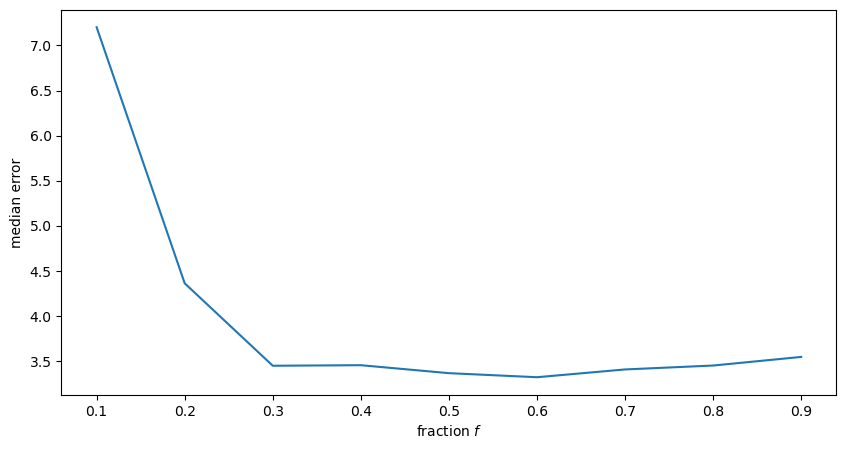

The code is listed below, below the data generation code. The median error decreases when the number of available samples gets larger, after a while, it minimally increases again slightly.



B - How many place cells do we need to reliably decode position? Try to re-do the decoding using only 10 cell, then 20, and so on. How does the median error change? Does it reach an asymptote? (Also in this case, you do not need to re-generate the data, you can just select a random subset of cells each time)

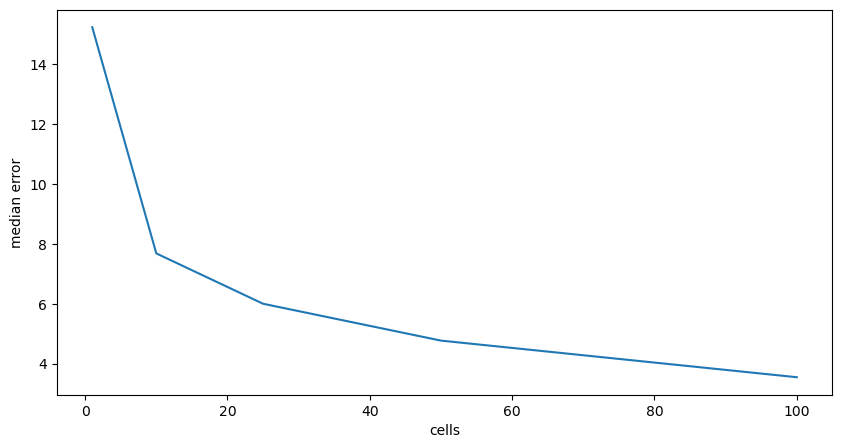

The code is listed below, below data generation code. The median error decreases with incremental increase in place cells, there seems to be a limit at around 100 cells. I can't go higher than 100 so I can't reliably say that an asymptote has been reached. To define a reliable number of cells we need to define a reliable median error, this will depend on the context of the data, but I suppose the maximum (100) is sufficient (median error of around 3.5). I'ts interesting how sharply the median error decreases in the beginning, with only about 15 place cells. 

C - Generate new data using the code below, changing the firing rate noise (changing the value of the variable `noise firing_rate`). How does this noise impact the decoding?

Code is listed below, below the data generation code. 

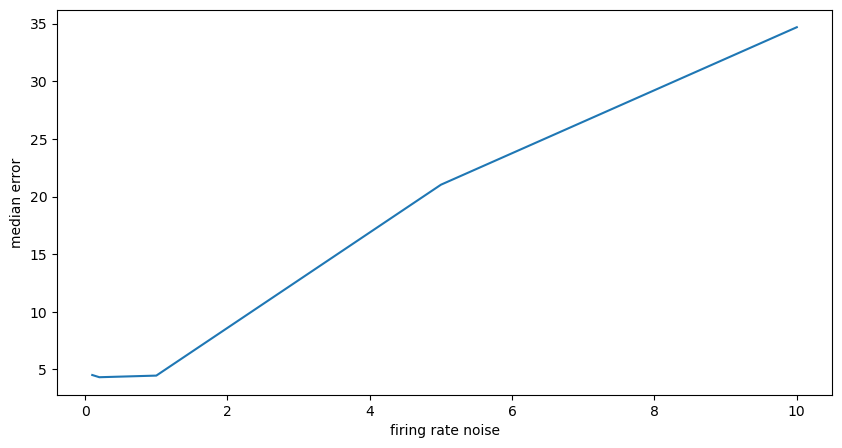

As expected, when noise is increased in the data the signal to noise ratio SNR is decreased, which increases the median error rate and makes the data less reliabe. 




## Exercise 2
---
In the loop implementation of the decoder, we used `poisson.logpmf(k,mu)` to calculate the log probability of observing $k$ spikes given an average firing rate of $\mu$. 
This is mathematically equivalent to `np.log(poisson.pmf(k,mu))`, in which we calculate the probability, and then take the log.


Re-run the decoding substituting this expression:

```
posterior[i] = sum(np.log(poisson.pmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15)))
```

To the line we are using to calculate the posterior.
Do you see any difference in the results? What do you think this is due to?

When using poisson.logpmf(k,mu) I get the following output.
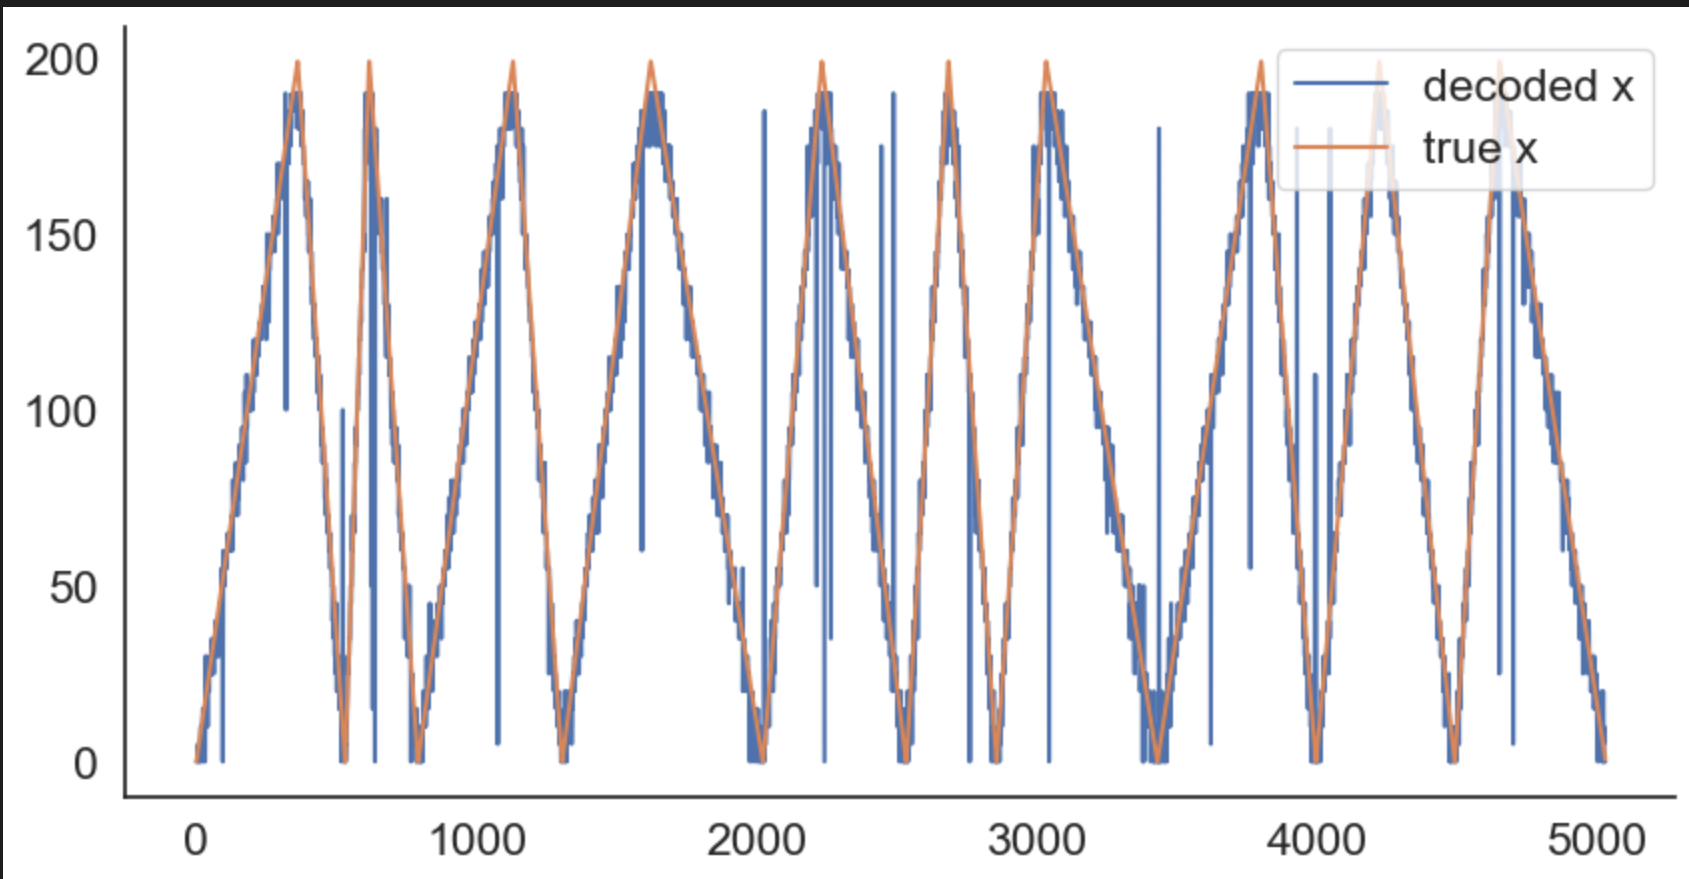

When using the other expression i get the following output.
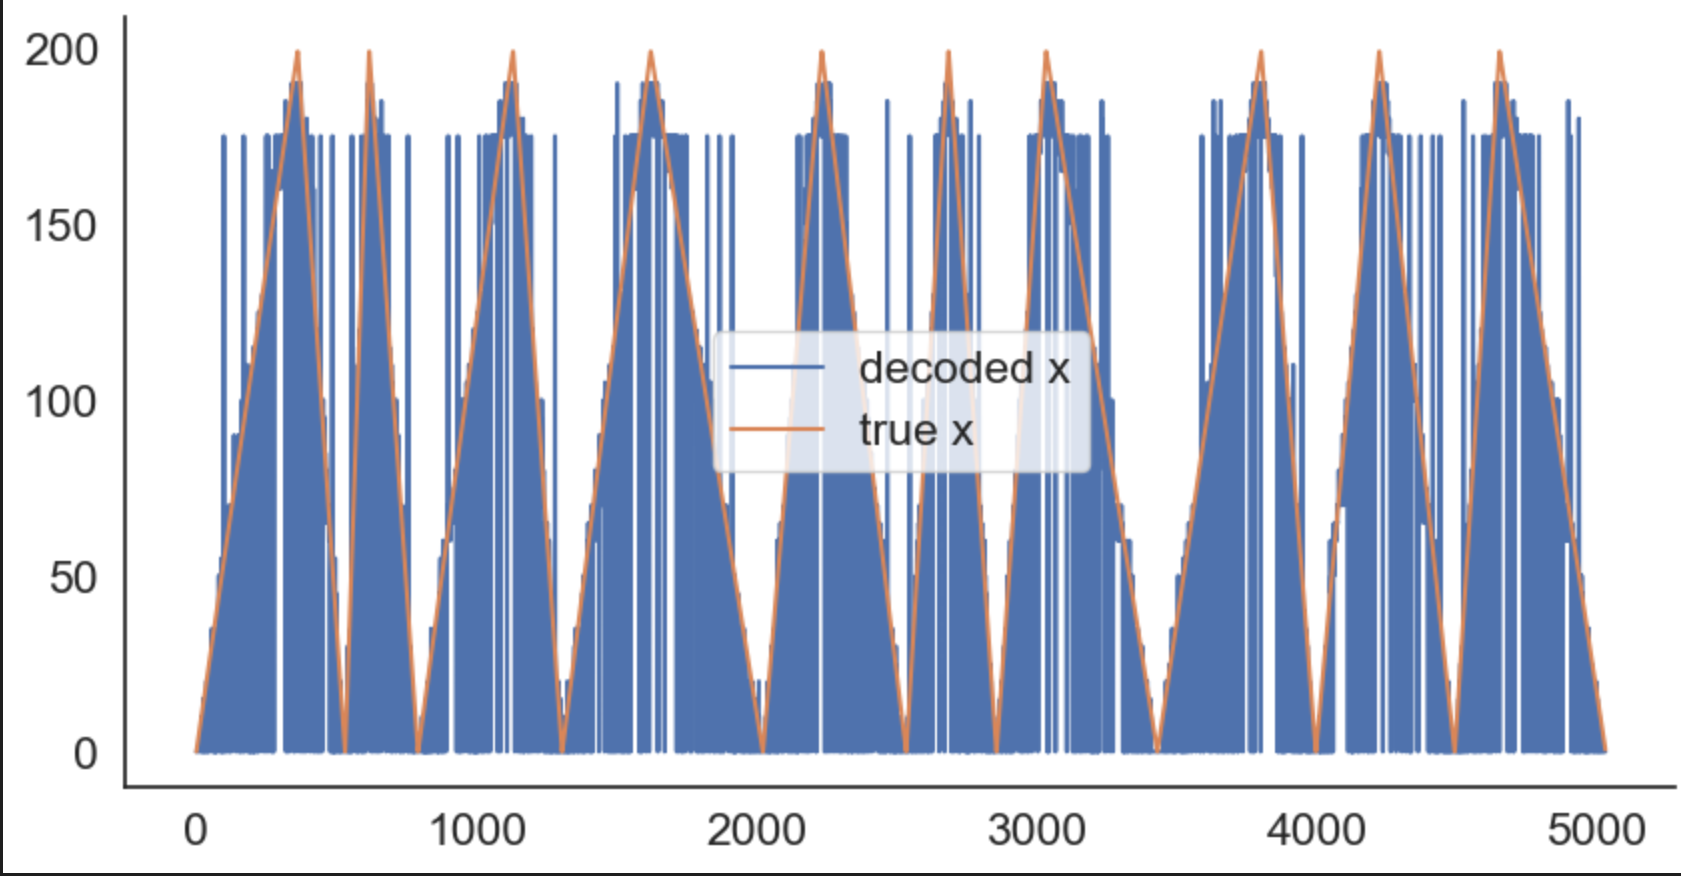

with the following error distribution:

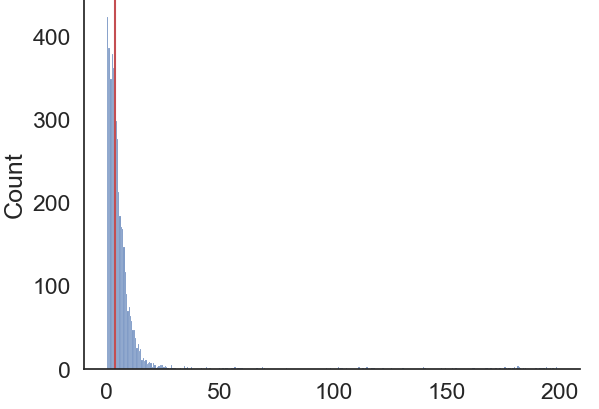

When using the possin.logpmf expression I get an error value of roughly 4.5 cm. When substituting I get a higher median error of around 5.
It seems that we are summing over the original equation where we take log of the probability of spike rate at that location. The neural activity of the mouse is better represented by the first figure, derived from the expression where we do not take the sum of the log of probability, however, there seems to be an overestimation occurring for values, as indicated by the blue line extending outside the true value of where the spike trains are firing. The second plot, where we sum over the log there is an over-representation as compared to the true value, I suspect this is due to many small probabilities being summed over. Taking the sum seems to be less accurate, as also indicated by the median error values. 



## Exercise 3
---
A - Estimate the quality of the sequence detection methods we saw in the lesson. How many false poistive does it find? How many false negatives?

Using the code below listed under data generation, I get a very low false positive count around 0. and the false negative count is comparatively high, 100. 

B - Investigate the effect of `noise_x_react` and `noise_t_react` on the false positive rate and the false negative rate of our detection procedure.

I get an error message and I am unable to visually plot the answer of this question. Asking for help from classmates and viewing their figure, I conclude that the noise level does not greatly impact the false positive and negative rate. Which is counter intuitive. When varying the parameters noise t and x react, I observe similar results.

C - What kind of sequence can our methods detect? What kind of activity, despide being sequential, could escape our detection method? Would you have an idea for a different method for sequence detection?

The first thing that comes to mind is the sampling rate at which the data is acquired, if the sampling rate is lower than the activity, this activity wont be accurately captured and represented in the analysis. This method also assumes linearity, when there is more non-linear data, this method may break down. Another way of detecting sequences would be to train a classifier or a neural network on a large dataset, and perform cross validation to assess performance. 


### Code for data generation

In [50]:
import numpy as np
import scipy
import scipy.stats
import scipy.io
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline 
plt.rcParams['figure.figsize'] = [10, 5]
from ipywidgets import interact
import ipywidgets as widgets
from scipy.stats import poisson


track_length = 200. # the length of our linear track (eg in centimeter)
average_firing_rate = 5 # the peak firing rate, averaged across the population 
n_cells = 100 # how many cells we are recording
pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
pf_size = np.random.gamma(10, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution 
pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution

In [51]:
bins = np.arange(0., 200.)
true_firing_rate_maps = np.zeros((n_cells, len(bins)))
for i in range(n_cells):
    true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))

In [52]:
# GENERATE TRAJECTORY

n_runs = 10
use_stops = False
av_running_speed = 10 # the average running speed (in cm/s)
fps = 10 # the number of "video frames" per second 
running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
running_speed_b = np.random.chisquare(10, size=n_runs) 

stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
stopping_time_b = np.random.chisquare(15, size=n_runs)

x = np.array([])


for i in range(n_runs):
    stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
    run_length = len(bins) * fps / running_speed_a[i]
    run1 = np.linspace(0., float(len(bins)-1), int(run_length))
    stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
    run_length = len(bins) * fps / running_speed_b[i]
    run2 = np.linspace(len(bins)-1., 0., int(run_length))
    if use_stops:
        x = np.concatenate((x, stop1, run1, stop2, run2))
    else:
         x = np.concatenate((x, run1, run2))
t = np.arange(len(x))/fps

In [53]:
sampling_rate = 10000.
t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
x_sampling = np.floor(np.interp(t_sampling, t, x))
noise_firing_rate = 0.1 # the baseline noise firing rate
spikes = []

for i in range(n_cells):
    inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
    spikes_loc = np.random.poisson(inst_rate/sampling_rate)
    sp = np.argwhere(spikes_loc)
    t_sp = t_sampling[sp]
    spikes.append(t_sp)

In [54]:
import pickle

file_name = 'linear_track_data.pickle' # change this name when you save new data

out_data = {}
out_data['x'] = x
out_data['t'] = t
out_data['spikes'] = spikes
out_data['track_length'] = track_length
out_data['fps'] = fps

with open('data/'+file_name,'wb') as f:
    pickle.dump(out_data,f)

Code to question 1 A

100%|██████████| 4319/4319 [00:09<00:00, 445.06it/s]


Text(0, 0.5, 'median error')

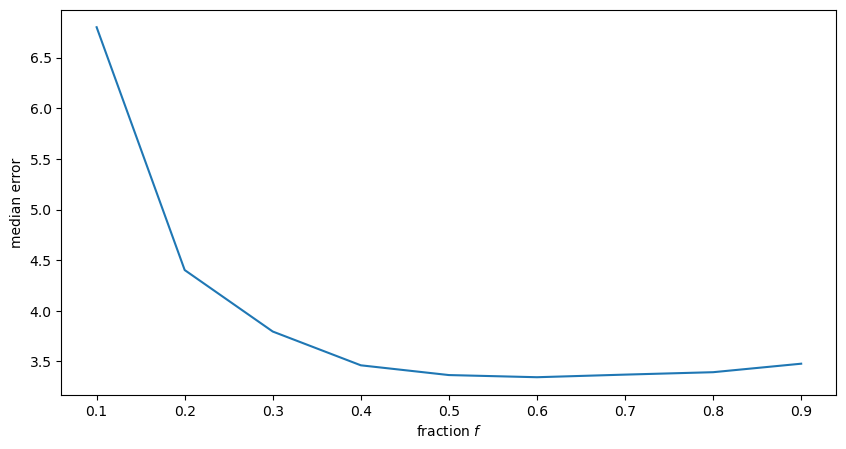

In [55]:
#fractions of data
fractions = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Decoding per fraction
median_errors = np.zeros(len(fractions))


for i in range(len(fractions)):
    fraction = fractions[i]
    num_samples = int(len(x) * fraction)
    random_indices = np.sort(np.random.choice(range(len(x)), size=num_samples, replace=False))
    sub_x = x[random_indices]
    sub_t = t[random_indices]
    spike_positions = [np.interp(s, sub_t, sub_x) for s in spikes]
    space_bins = np.arange(0., track_length, 5.) 
   

 # we compute histograms for each cell
    spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]
    spikes_hist = np.asarray(spikes_hist) #np.vstack(spikes_hist).astype(np.float64)

    # we also need an "occupancy histogram" in order to normalize the firing rates maps 
    occupancy = np.histogram(sub_x, space_bins)[0] /  fps
    
    firing_rate_maps = spikes_hist / occupancy 

    spikes_count= [np.histogram(s,sub_t)[0] for s in spikes]
    spikes_count = np.asarray(spikes_count).T # we transpose the matrix to have the more familiar samples x features shape

    true_x = sub_x[:-1]
    decoding_times = sub_t[:-1]
    x_decoded = np.zeros_like(true_x)

    #calculate posterior and decode
    for t_bin in tqdm(range(len(decoding_times))):
        if sum(spikes_count[t_bin,:])>0: # Check if the time window contains spikes
            posterior = np.empty(firing_rate_maps.shape[-1])

            for j in range(len(posterior)):
                                #posterior[i] = sum(np.log(poisson.pmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15)))
                posterior[j] = sum(poisson.logpmf(spikes_count[t_bin,:],firing_rate_maps[:,j]/fps)+pow(1,-15))


            x_decoded[t_bin] = space_bins[np.argmax(posterior)]
        else:
            x_decoded[t_bin] = np.nan   

    #compute error
    mse = np.sqrt((true_x-x_decoded)**2)
    median_error = np.nanmedian(np.sqrt((true_x-x_decoded)**2))
    median_errors[i] = median_error


plt.plot(fractions,median_errors)
plt.xlabel('fraction $f$')
plt.ylabel('median error')

In the plot above we can clearly see the median error decreases per fraction, and then minimally increases again. 

Code to question 1 B

100%|██████████| 4799/4799 [00:10<00:00, 473.37it/s]


Text(0, 0.5, 'median error')

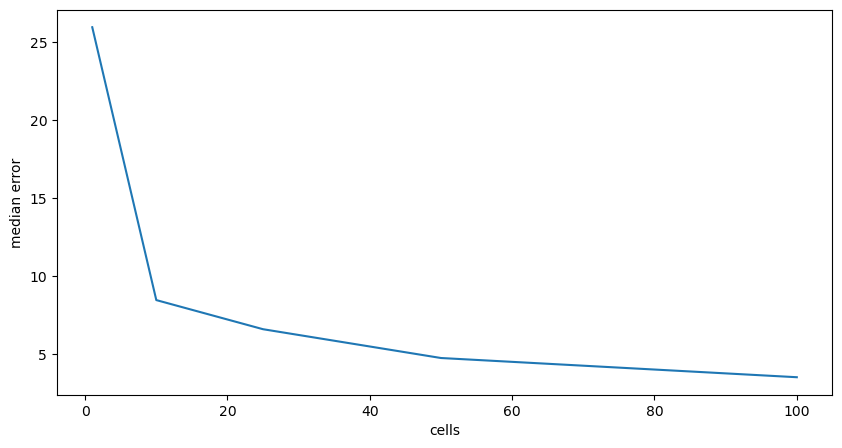

In [56]:
n_cells_list = [1, 10, 25, 50, 100 ] # how many cells we are recording

median_errors = np.zeros(len(n_cells_list))

for i in range(len(n_cells_list)):
    num_cells = n_cells_list[i]
    random_indices = np.sort(np.random.choice(len(spikes), size=num_cells, replace=False))
    sub_spikes = [spikes[i] for i in random_indices]
    spike_positions = [np.interp(s, t, x) for s in sub_spikes]
    space_bins = np.arange(0., track_length, 5.) 

    # we compute histograms for each cell
    spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]
    spikes_hist = np.asarray(spikes_hist) #np.vstack(spikes_hist).astype(np.float64)

    # we also need an "occupancy histogram" in order to normalize the firing rates maps 
    occupancy = np.histogram(x, space_bins)[0] /  fps
    
    firing_rate_maps = spikes_hist / occupancy 

    spikes_count= [np.histogram(s,t)[0] for s in sub_spikes]
    spikes_count = np.asarray(spikes_count).T # we transpose the matrix to have the more familiar samples x features shape

    true_x = x[:-1]
    decoding_times = t[:-1]
    x_decoded = np.zeros_like(true_x)
    #calculate posterior and decode
    for t_bin in tqdm(range(len(decoding_times))):
        if sum(spikes_count[t_bin,:])>0: # Check if the time window contains spikes
            posterior = np.empty(firing_rate_maps.shape[-1])

            for j in range(len(posterior)):
                
                posterior[j] = sum(poisson.logpmf(spikes_count[t_bin,:],firing_rate_maps[:,j]/fps)+pow(1,-15))


            x_decoded[t_bin] = space_bins[np.argmax(posterior)]
        else:
            x_decoded[t_bin] = np.nan   

    #compute error
    mse = np.sqrt((true_x-x_decoded)**2)
    median_error = np.nanmedian(np.sqrt((true_x-x_decoded)**2))
    median_errors[i] = median_error

plt.plot(n_cells_list,median_errors)
plt.xlabel('cells')
plt.ylabel('median error')

As the number of cells increases, the median error decreases as more information is used. 

Code to question 1 C

100%|██████████| 4799/4799 [00:10<00:00, 466.71it/s]


Text(0, 0.5, 'median error')

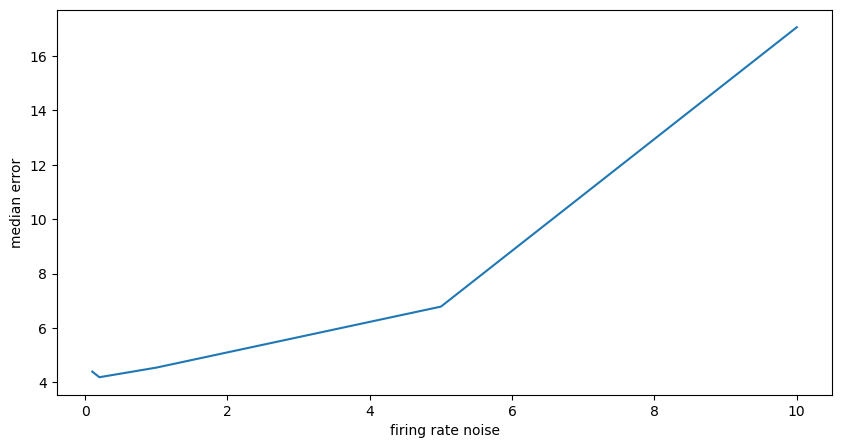

In [57]:
noise_firing_rates = np.array([.1,.2,1,5,10]) # the baseline noise firing rate
    
median_errors = np.zeros(len(noise_firing_rates))

for i in range(len(noise_firing_rates)):
    noise_firing_rate = noise_firing_rates[i]
    spikes = []
    for idx in range(n_cells):
        inst_rate = true_firing_rate_maps[idx,x_sampling.astype(np.int32)] + noise_firing_rate
        spikes_loc = np.random.poisson(inst_rate/sampling_rate)
        sp = np.argwhere(spikes_loc)
        t_sp = t_sampling[sp]
        spikes.append(t_sp)
    
    spike_positions = [np.interp(s, t, x) for s in spikes]
    space_bins = np.arange(0., track_length, 5.) # binnin in bins of 5 cms

    # we compute histograms for each cell
    spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]
    spikes_hist = np.asarray(spikes_hist)#np.vstack(spikes_hist).astype(np.float64)

    # we also need an "occupancy histogram" in order to normalize the firing rates maps 
    occupancy = np.histogram(x, space_bins)[0] /  fps   
    firing_rate_maps = spikes_hist / occupancy 

    spikes_count= [np.histogram(s,t)[0] for s in sub_spikes]
    spikes_count = np.asarray(spikes_count).T # we transpose the matrix to have the more familiar samples x features shape

    true_x = x[:-1]
    decoding_times = t[:-1]
    x_decoded = np.zeros_like(true_x)

    #calculate posterior and decode
    for t_bin in tqdm(range(len(decoding_times))):
        if sum(spikes_count[t_bin,:])>0: # Check if the time window contains spikes
            posterior = np.empty(firing_rate_maps.shape[-1])

            for j in range(len(posterior)):
                              
                posterior[j] = sum(poisson.logpmf(spikes_count[t_bin,:],firing_rate_maps[:,j]/fps)+pow(1,-15))


            x_decoded[t_bin] = space_bins[np.argmax(posterior)]
        else:
            x_decoded[t_bin] = np.nan   

    #compute error
    mse = np.sqrt((true_x-x_decoded)**2)
    median_error = np.nanmedian(np.sqrt((true_x-x_decoded)**2))
    median_errors[i] = median_error

plt.plot(noise_firing_rates,median_errors)
plt.xlabel('firing rate noise')
plt.ylabel('median error')

As suspected, median error increases when noise is increased. 

Code to question 3A

In [58]:
n_events = 200 # number of reactivation events
event_duration = 100 # in bins
sampling_rate = 100 # sampling rate 
t_react = np.arange(0,100)
noise_x_react=5; # Noise in the reactivation of the sequence
noise_t_react=5; # Noise in the timing of the spikes 
noise_firing_rate = .1 # the baseline noise firing rate


reactivation_events = np.zeros((n_events,event_duration))
spikes_react = np.zeros((n_events,n_cells,event_duration))

for event in range(n_events):
    if(event<=n_events//2):
    #Generate "real" sequences for the first half of events
        x_start = np.random.uniform(0,track_length) # Starting point
        x_end = np.random.uniform(0,track_length) # Ending point
        x_react = np.linspace(x_start,x_end,event_duration) \
            +np.random.normal(0,noise_x_react,size=event_duration)

    else:
        #Pick locations randomly for the second half 
        x_react = np.random.uniform(0,track_length,size=event_duration);

    x_react[x_react<0]=0;
    x_react[x_react>track_length]=track_length
    
    #store reactivation sequence
    reactivation_events[event,:] = x_react

    
    # Generate spikes according to the location being reactivated in this event
    
    for i in range(n_cells):
        binned_x = np.digitize(x_react,bins=np.linspace(0,track_length,firing_rate_maps.shape[-1]))-1
        inst_rate = firing_rate_maps[i,binned_x] + np.random.normal(0,noise_firing_rate,size=len(binned_x))
        inst_rate[inst_rate<0] = 0
        spikes_loc = np.where(np.random.poisson(inst_rate/sampling_rate)>0)
        spikes_loc = spikes_loc + np.round(np.random.normal(0,noise_t_react,size=len(spikes_loc)))
        spikes_loc = spikes_loc[np.logical_and(spikes_loc>0,spikes_loc<event_duration)]
        spikes_react[event,i,spikes_loc.astype(int)] = 1

pfc_idxs = [np.argmax(rate_map) for rate_map in firing_rate_maps] 
sorted_idxs = np.argsort(pfc_idxs)

In [59]:
time_window = 10 # number of bins to aggregate during decoding

reactivation_slope = np.zeros(n_events)

for event in range(n_events):

    event_spikes = spikes_react[event]
    # First we bin the events in windows of 10 bins
    spikes_sampled = np.zeros((n_cells,event_spikes.shape[1]//time_window))
    # We generate a new spike matrix with the re-sized window
    for t_r in range(1,event_spikes.shape[1]//time_window):
        spikes_sampled[:,t_r] = np.sum(event_spikes[:,(t_r-1)*time_window :(t_r)*time_window],axis=1)

In [60]:
# to do: bayesian decoding
from scipy.stats import poisson
from scipy.stats import pearsonr

t_resize = 10 # We use spikes from multiple time windows for the decoding

reactivation_slopes = np.zeros(n_events)
reactivation_pvalues = np.zeros(n_events)

for event in range(n_events):

    event_spikes = spikes_react[event]
    spikes_sampled = np.zeros((n_cells,event_spikes.shape[1]//t_resize))

    # We generate a new spike matrix with the re-sized window
    for t_r in range(1,event_spikes.shape[1]//t_resize):
        spikes_sampled[:,t_r] = np.sum(event_spikes[:,(t_r-1)*t_resize :(t_r)*t_resize],axis=1)


    # We then perform decoding on the aggregated spikes
    x_decoded = np.zeros(spikes_sampled.shape[1])

    for t_bin in range(spikes_sampled.shape[1]):

        if sum(spikes_count[t_bin,:])>0: # Check if the time window contains spikes

            posterior = np.empty(firing_rate_maps.shape[-1])
            for i in range(len(posterior)):
                posterior[i] = sum(poisson.logpmf(spikes_sampled[:,t_bin],firing_rate_maps[:,i]*t_resize/fps)+pow(1,-15))

            x_decoded[t_bin] = space_bins[np.argmax(posterior)]

        else:
            x_decoded[t_bin] = np.nan   

        # We fit a line to the decoded positions, and save the slope
        idx = np.isfinite(x_decoded)
        slope,_ = np.polyfit(np.arange(len(x_decoded[idx])),x_decoded[idx],deg=1)
        reactivation_slopes[event] = slope
        # And calculate the pvalue of the pearson correlation
        corr = pearsonr(np.arange(len(x_decoded[idx])),x_decoded[idx])
        reactivation_pvalues[event] = corr[1]

c:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [61]:
sequential_event_indices = []
threshold = 0.05

for event in range(n_events):
    if reactivation_pvalues[event] < threshold:
        sequential_event_indices.append(event)
        
sequential_event_indices = np.array(sequential_event_indices)

In [62]:
ground_truth = np.arange(100) #first 100 events are sequential
false_positives = np.setdiff1d(sequential_event_indices, ground_truth) #returns set difference between arrays
false_negatives = np.setdiff1d(ground_truth, sequential_event_indices)
false_positive_count = len(false_positives)
false_negative_count = len(false_negatives)

print(false_positive_count)
print(false_negative_count)


0
100


The false positive count is very low, around 0. and the false negative count is comparatively high, 100

Code for 3B

100%|██████████| 10/10 [01:14<00:00,  7.49s/it]


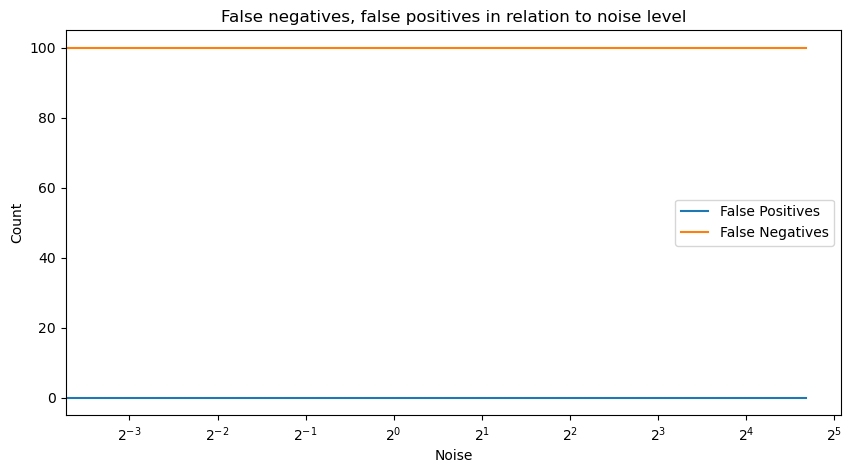

In [64]:
vals = np.array([0,.1,.2,.4,.8,1.6,3.2,6.4,12.8,25.6])
false_positives_negatives = np.zeros([len(vals),2]) #first column is false positives


for j in tqdm(range(len(vals))):
    noise_x_react = vals[j]; #or set to a scalar and change the other
    noise_t_react = vals[j]; 
    reactivation_events = np.zeros((n_events,event_duration))
    spikes_react = np.zeros((n_events,n_cells,event_duration))
    for event in range(n_events):
        if(event<=n_events//2):
        #Generate "real" sequences for the first half of events
            x_start = np.random.uniform(0,track_length) # Starting point
            x_end = np.random.uniform(0,track_length) # Ending point
            x_react = np.linspace(x_start,x_end,event_duration) \
                +np.random.normal(0,noise_x_react,size=event_duration)

        else:
            #Pick locations randomly for the second half 
            x_react = np.random.uniform(0,track_length,size=event_duration);

        x_react[x_react<0]=0
        x_react[x_react>track_length]=track_length
    
        #store reactivation sequence
        reactivation_events[event,:] = x_react

    
        # Generate spikes according to the location being reactivated in this event
    
        for i in range(n_cells):
            binned_x = np.digitize(x_react,bins=np.linspace(0,track_length,firing_rate_maps.shape[-1]))-1
            inst_rate = firing_rate_maps[i,binned_x] + np.random.normal(0,noise_firing_rate,size=len(binned_x))
            inst_rate[inst_rate<0] = 0
            spikes_loc = np.where(np.random.poisson(inst_rate/sampling_rate)>0)
            spikes_loc = spikes_loc + np.round(np.random.normal(0,noise_t_react,size=len(spikes_loc)))
            spikes_loc = spikes_loc[np.logical_and(spikes_loc>0,spikes_loc<event_duration)]
            spikes_react[event,i,spikes_loc.astype(int)] = 1    
            
    time_window = 10 # number of bins to aggregate during decoding

    reactivation_slope = np.zeros(n_events)

    for event in range(n_events):

        event_spikes = spikes_react[event]
        # First we bin the events in windows of 10 bins
        spikes_sampled = np.zeros((n_cells,event_spikes.shape[1]//time_window))
        # We generate a new spike matrix with the re-sized window
        for t_r in range(1,event_spikes.shape[1]//time_window):
            spikes_sampled[:,t_r] = np.sum(event_spikes[:,(t_r-1)*time_window :(t_r)*time_window],axis=1) 
     
    t_resize = 10 # We use spikes from multiple time windows for the decoding

    reactivation_slopes = np.zeros(n_events)
    reactivation_pvalues = np.zeros(n_events)

    for event in range(n_events):

        event_spikes = spikes_react[event]
        spikes_sampled = np.zeros((n_cells,event_spikes.shape[1]//t_resize))

        # We generate a new spike matrix with the re-sized window
        for t_r in range(1,event_spikes.shape[1]//t_resize):
            spikes_sampled[:,t_r] = np.sum(event_spikes[:,(t_r-1)*t_resize :(t_r)*t_resize],axis=1)


        # We then perform decoding on the aggregated spikes
        x_decoded = np.zeros(spikes_sampled.shape[1])

        for t_bin in range(spikes_sampled.shape[1]):

            if sum(spikes_count[t_bin,:])>0: # Check if the time window contains spikes

                posterior = np.empty(firing_rate_maps.shape[-1])
                for i in range(len(posterior)):
                    posterior[i] = sum(poisson.logpmf(spikes_sampled[:,t_bin],firing_rate_maps[:,i]*t_resize/fps)+pow(1,-15))

                x_decoded[t_bin] = space_bins[np.argmax(posterior)]

            else:
                x_decoded[t_bin] = np.nan   

            # We fit a line to the decoded positions, and save the slope
            idx = np.isfinite(x_decoded)
            slope,_ = np.polyfit(np.arange(len(x_decoded[idx])),x_decoded[idx],deg=1)
            reactivation_slopes[event] = slope
            # And calculate the pvalue of the pearson correlation
            corr = pearsonr(np.arange(len(x_decoded[idx])),x_decoded[idx])
            reactivation_pvalues[event] = corr[1]
            
    sequential_event_indices = []
    threshold = 0.05

    for event in range(n_events):
        if reactivation_pvalues[event] < threshold:
            sequential_event_indices.append(event)
        
    sequential_event_indices = np.array(sequential_event_indices)

    ground_truth = np.arange(100) #first 100 events are sequential
    false_positives = np.setdiff1d(sequential_event_indices, ground_truth) #returns set difference between arrays
    false_negatives = np.setdiff1d(ground_truth, sequential_event_indices)
    false_positive_count = len(false_positives)
    false_negative_count = len(false_negatives)
    false_positives_negatives[j,0]=false_positive_count
    false_positives_negatives[j,1]=false_negative_count
    
false_positives_negatives

plt.plot(vals, false_positives_negatives[:,0], label='False Positives')
plt.plot(vals, false_positives_negatives[:,1], label='False Negatives')
plt.xscale('log', base=2)
plt.xlabel('Noise')
plt.ylabel('Count')
plt.title('False negatives, false positives in relation to noise level')
plt.legend()
plt.show()

There seems to be an error in the generation of the plot. After interpreting other classmates figures, I can conclude that the noise level does not greatly influence the false negative/positive rate. 